Let's use Keras on the MNIST data set ,using a Convolutional Neural Network that's better suited for image processing.

We'll start by importing the stuff we need.

In [1]:
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop

We'll load up our mnist dataset:

In [2]:
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()


We need to reshape the data. Since we're treating the data as 2D images of 28x28 pixels instead of a flattened stream of 784 pixels, we need to shape it accordingly. Depending on the data format Keras is set up for, this may be 1x28x28 or 28x28x1 (the "1" indicates a single color channel, as this is just grayscale. If we were dealing with color images, it would be 3 instead of 1 since we'd have red, green, and blue color channels)

In [3]:
from tensorflow.keras import backend as K

if K.image_data_format() == 'channels_first':
    train_images = mnist_train_images.reshape(mnist_train_images.shape[0], 1, 28, 28)
    test_images = mnist_test_images.reshape(mnist_test_images.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    train_images = mnist_train_images.reshape(mnist_train_images.shape[0], 28, 28, 1)
    test_images = mnist_test_images.reshape(mnist_test_images.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)
    
train_images = train_images.astype('float32')  #the data is of 8-bits so we normalize it by converting to floating point 32 bit values 
test_images = test_images.astype('float32')
train_images /= 255   #so that now every pixel lies b/w 0 and 1
test_images /= 255

As before we need to convert our train and test labels to be categorical in one-hot format(for numbers between 0-9):

In [4]:
train_labels = tensorflow.keras.utils.to_categorical(mnist_train_labels, 10)
test_labels = tensorflow.keras.utils.to_categorical(mnist_test_labels, 10)
print(train_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


As a sanity check let's print out one of the training images with its label:

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


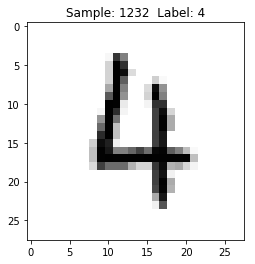

In [6]:
import matplotlib.pyplot as plt

def display_sample(num):
    #Print the one-hot array of this sample's label 
    print(train_labels[num])  
    #Print the label converted back to a number(0-9)
    label = train_labels[num].argmax(axis=0)
    #Reshape the 768 values to a 28x28 image
    image = train_images[num].reshape([28,28])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))   #to plot inverse gray scale image
    plt.savefig('foo.png')
    plt.show()
display_sample(1232)

Setting up a convolutional neural network involves many layers. Not all of these are strictly necessary;we could run without pooling and dropout layers, but those help avoid overfitting and help things run faster.

We'll start with a 2D convolution of the image - it's set up to take 32 windows, or "filters", of each image, each filter being 3x3 in size.

We then run a second convolution on top of that with 64 3x3 windows - this topology is recommended within Keras. 

Next we apply a MaxPooling2D layer that takes the maximum of each 2x2 result to distill the results down into something more manageable.

A dropout filter is then applied to prevent overfitting.

Next we flatten the 2D layer we have at this stage into a 1D layer. So at this point we can just pretend we have a traditional multi-layer perceptron.

and feed that into a hidden, flat layer of 128 units.

We then apply dropout again to further prevent overfitting.

And finally, we feed that into our final 10 units where softmax is applied to choose our category of 0-9.

In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
# 64 3x3 kernels
model.add(Conv2D(64, (3, 3), activation='relu'))
# Reduce by taking the max of each 2x2 block
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout to avoid overfitting
model.add(Dropout(0.25))
# Flatten the results to one dimension for passing into our final layer
model.add(Flatten())
# A hidden layer to learn with
model.add(Dense(128, activation='relu'))
# Another dropout
model.add(Dropout(0.5))
# Final categorization from 0-9 with softmax
model.add(Dense(10, activation='softmax'))

Let's double check the model description:

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

We are doing multiple categorization, so categorical_crossentropy is still the right loss function. We'll use the adam optimizer .I tried using the RMSprop optimizer but the accuracy was decreasing with each epoch . it was overfitting the training data.

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

And now we train our model... to make things go a little faster, we'll use batches of 32.

now we are going to print the progess in each epoch.

In [10]:
history = model.fit(train_images, train_labels,
                    batch_size=32,
                    epochs=10,
                    verbose=2,
                    validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 160s - loss: 0.1910 - acc: 0.9413 - val_loss: 0.0493 - val_acc: 0.9834
Epoch 2/10
 - 154s - loss: 0.0791 - acc: 0.9765 - val_loss: 0.0334 - val_acc: 0.9895
Epoch 3/10
 - 154s - loss: 0.0598 - acc: 0.9821 - val_loss: 0.0303 - val_acc: 0.9905
Epoch 4/10
 - 153s - loss: 0.0493 - acc: 0.9850 - val_loss: 0.0279 - val_acc: 0.9912
Epoch 5/10
 - 156s - loss: 0.0418 - acc: 0.9871 - val_loss: 0.0313 - val_acc: 0.9904
Epoch 6/10
 - 153s - loss: 0.0350 - acc: 0.9891 - val_loss: 0.0354 - val_acc: 0.9899
Epoch 7/10
 - 154s - loss: 0.0317 - acc: 0.9902 - val_loss: 0.0321 - val_acc: 0.9910
Epoch 8/10
 - 152s - loss: 0.0295 - acc: 0.9910 - val_loss: 0.0305 - val_acc: 0.9911
Epoch 9/10
 - 154s - loss: 0.0246 - acc: 0.9920 - val_loss: 0.0294 - val_acc: 0.9928
Epoch 10/10
 - 152s - loss: 0.0248 - acc: 0.9921 - val_loss: 0.0303 - val_acc: 0.9918


Was it worth the wait?

In [11]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.030270281564952713
Test accuracy: 0.9918


Over 99%! And that's with just 10 epochs.